### LangGraph 활용 Agent 구축 

In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [1]:
from langchain_teddynote import logging

logging.langsmith("edu-CH17-LangGrapht-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
edu-CH17-LangGrapht-Modules


### 도구(Tool) 사용

In [2]:
from langchain_teddynote.tools.tavily import TavilySearch

tool = TavilySearch(max_results=3)

tools = [tool]

print(tool.invoke("테디노트 랭체인 튜토리얼"))

[{'title': '랭체인 (langchain)의 OpenAI GPT 모델 (ChatOpenAI) 사용법 (1) - 테디노트', 'url': 'https://teddylee777.github.io/langchain/langchain-tutorial-01/', 'content': '② LangChain 한국어 튜토리얼 바로가기 👀 ③ 랭체인 노트 무료 전자책(wikidocs) 바로가기 🙌 ④ RAG 비법노트 LangChain 강의오픈 바로가기 🙌 ⑤ 서울대 PyTorch 딥러닝 강의 바로가기 🙌 랭체인(langchain)의 OpenAI GPT 모델(ChatOpenAI) 사용법 (1) 2023년 09월 28일 5 분 소요 목차 🌱 랭체인의 주요 기능 🌱 환경설정 API KEY 발급 모듈 설치(openai, langchain) 🔥 ChatOpenAI 🔥 프롬프트 템플릿의 활용 LLMChain 객체 ① run() ② apply() ③ generate() ④ 2개 이상의 변수를 템플릿 안에 정의 ⑤ 스트리밍(streaming) 언어 모델을 활용한 애플리케이션 개발을 돕는 프레임워크인 랭체인(LangChain) 에 대해 깊이 있게 다뤄보고자 합니다. 튜토리얼은 시리즈 형식으로 구성되어, 시리즈를 거듭하면서 랭체인(LangChain) 을 통해 언어 모델 기반의 애플리케이션 개발은 더욱 간결하고 효과적으로 이루어질 수 있습니다. 추론 능력: 제공된 문맥에 기반하여 어떤 대답을 할지, 또는 어떠한 액션을 취할지에 대한 추론이 가능합니다. 특히, 이러한 사용 준비된 체인은 초보자도 랭체인을 쉽게 시작할 수 있게 도와주며, 복잡한 애플리케이션을 계획하는 전문가들은 기존 체인을 손쉽게 커스터마이징하거나 새롭게 구축할 수 있게 도와줍니다.', 'score': 0.854509, 'raw_content': "랭체인(langchain)의 OpenAI GPT 모델(ChatOpenAI) 사용법 (1) - 테디노트\n\nSkip to primary navigation\nSkip to cont

In [18]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [19]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

llm_with_tools = llm.bind_tools(tools)

In [20]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}

In [21]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

### Tool Node

In [22]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}

tool_node = BasicToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)

### 조건부 엣지(Conditional Edge)

In [23]:
from langgraph.graph import START, END

def route_tools(state: State):
    if messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools, 
    path_map={"tools": "tools", END: END}
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

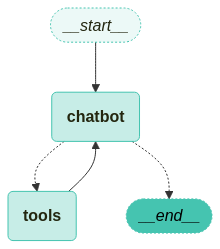

In [24]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [25]:
inputs = {"messages": "테디노트 YouTube 채널에 대해서 검색해 줘"}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value[-1])


STEP: messages

content='테디노트 YouTube 채널에 대해서 검색해 줘' additional_kwargs={} response_metadata={} id='0dbb99b4-6185-474f-8567-050e2c2c070f'

STEP: messages

content='' additional_kwargs={'tool_calls': [{'id': 'call_eieXgso3t8PtJKvsUHrGLVVU', 'function': {'arguments': '{"query":"테디노트 YouTube 채널"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 105, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411', 'id': 'chatcmpl-BG8NTXVHkdh8oB646dily4zSaiqOk', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-bcd4efbb-828c-4eba-952d-6e0d1078b5aa-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '테디노트 YouTube 채널'}, 'id': 'call_eieXgso3t